# simulatorクラスの定義


PHYSBOではSimulator関数を使用して目的関数を定義します。
ここでは、一次元の関数の最小値を求める例題をもとに、simulatorクラスの定義方法について紹介します。

## 探索空間の定義

その他のチュートリアルと同じように、最初に関数を探索する空間を定義します。
以下の例では、探索空間``X``を ``x_min = -2.0``から``x_max = 2.0``まで``window_num=10001``分割で刻んだグリッドで定義しています。
なお、``X``は ``window_num x d`` のndarray形式にする必要があります(``d``は次元数)。そのため、reshapeを行って変形しています。

In [1]:
#In
import numpy as np
import scipy
import physbo
import os
import urllib
import itertools

#In
#Create candidate
window_num=10001
x_max = 2.0
x_min = -2.0

X = np.linspace(x_min,x_max,window_num).reshape(window_num, 1)

## simulatorクラスの定義

目的関数を定義するためのsimulatorクラスをここで定義します。

今回はf(x) = 3 x^4 + 4 x ^3 + 1.0 が最小となるxを探索するという問題設定にしています(答えはx=-1.0)。

simulatorクラスでは、``__call__``関数を定義します(初期変数などがある場合は``__init__``を定義します)。
actionは探索空間の中から取り出すグリッドのindex番号を示しており、複数の候補を一度に計算できるように一般的にndarrayの形式を取っています。
今回は一つの候補のみを毎回計算するため、``action_idx=action[0]``として``X``から候補点を一つ選んでいます。
PHYSBOでは目的関数値に-1をかけたものが最大となるものを求める仕様になっているため、``delta``に候補点でのf(x)の値をいれ、最後に-1をかけたものを返しています。

In [2]:
# Declare the class for calling the simulator.
class simulator:

    def __call__(self, action ):
        action_idx = action[0]
        x = X[action_idx][0]
        delta = 3.0*x**4 + 4.0*x**3 + 1.0
        delta_list.append(delta)
        x_list.append(X[action_idx][0])

        print ("*********************")
        print ("Present optimum interactions")

        print ("x_opt=", x_list[np.argmin(np.array(delta_list))])

        return -delta, x

## ランダムサーチ

ベイズ最適化を行う前に、探索空間からランダムに点を求め事前にトレーニングデータを用意します(飛ばすことも可能です)。

In [ ]:
delta_list=[]
x_list = []
#In
# Design of policy
# Declaring the policy by
policy = physbo.search.discrete.policy(test_X=X)
# test_X is the set of candidates which is represented by numpy.array.
# Each row vector represents the feature vector of the corresponding candidate

# set the seed parameter
policy.set_seed( 1 )


# If you want to perform the initial random search before starting the Bayesian optimization,
# the random sampling is performed by

res = policy.random_search(max_num_probes=50, simulator=simulator())
# Input:
# max_num_probes: number of random search
# simulator = simulator
# output: combo.search.discreate.results (class)

## ベイズ最適化

定義したsimulatorに対してベイズ最適化を実施します。

In [ ]:
# single query Bayesian search
# The single query version of COMBO is performed by
res = policy.bayes_search(max_num_probes= 150, simulator=simulator(), score='TS',
                                                  interval=20, num_rand_basis=2000)

# Input
# max_num_probes: number of searching by Bayesian optimization
# simulator: the class of simulator which is defined above
# score: the type of aquision funciton. TS, EI and PI are available
# interval: the timing for learning the hyper parameter.
#               In this case, the hyper parameter is learned at each 20 steps
#               If you set the negative value to interval, the hyper parameter learning is not performed
#               If you set zero to interval, the hyper parameter learning is performed only at the first step
# num_rand_basis: the number of basis function. If you choose 0,  ordinary Gaussian process runs

## 結果表示

得られた結果のうち、一番よいスコアを持つものは``export_all_sequence_best_fx()``を用いることで取り出すことができます。
また、これまでの全ての履歴をみたい場合には、``chosed_actions``を呼び出すことで表示することができます。以下、結果を表示するサンプルスクリプトを記載します。

In [5]:
#In
best_fx, best_action = res.export_all_sequence_best_fx()

import matplotlib.pyplot as plt
# The result of searching is summarized in the class combo.search.discrete.results.history()
# res.fx: observed negative energy at each step
# res.chosed_actions: history of choosed actions
# fbest, best_action= res.export_all_sequence_best_fx(): current best fx and current best action
#                                                                                                   that has been observed until each step
# res.total_num_search: total number of search
plt.plot(res.fx[0:res.total_num_search])

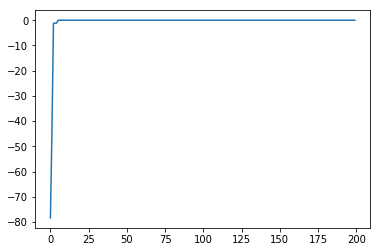

In [6]:
plt.plot(best_fx)

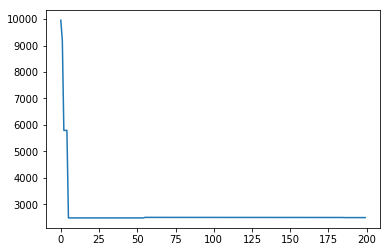

In [7]:
plt.plot(best_action)

最後に、一番よいスコアを持つ候補は以下のようにして表示することができます。正しい解 x=-1に行き着いていることがわかります。

In [8]:
print(X[int(best_action[-1])])

[-1.]
